In [87]:
%pip install yfinance pandas_ta scikit-learn matplotlib statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\sparsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [126]:

import yfinance as yf
import statsmodels.api as sm

#symbols = ['NLCINDIA.NS', 'NTPC.NS']
symbols = [
    "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
    "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
    "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
    "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
    "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS",
    "INDUSINDBK.NS", "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LTIM.NS",
    "LT.NS", "M&M.NS", "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS",
    "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS",
    "TECHM.NS", "TITAN.NS", "UPL.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]


df = yf.download(symbols, start="2000-01-01")['Close'].dropna()

print(df.head())

[*********************100%***********************]  50 of 50 completed


Ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2017-11-17    83.979095     384.685028    1029.646362    1109.959961   
2017-11-20    86.016907     382.430420    1034.282593    1105.269043   
2017-11-21    82.289864     384.541138    1081.331177    1099.536011   
2017-11-22    84.622620     397.685394    1122.034790    1112.802734   
2017-11-23    81.780396     390.585571    1112.322754    1098.872681   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
Date                                                                   
2017-11-17   539.377197    2637.366455     511.470093    1751.500488   
2017-11-20   542.111755    2666.274170     515.837341    1769.041748   
2017-11-21   543.752502    2714.179688     519.092712    1773.451538   
2017-11-22   537.487732    2724.830078     516.116516    1738.369385   
2017-11-23   541.117371    2684.902100     511.854095    1728.2

In [127]:
# Filtering out correlated stocks.

filtered_pairs = []
corr_matrix = df.corr()
corr_threshold = 0.8

for i in range(len(symbols)):
  for j in range(i + 1, len(symbols)):
    s1, s2 = symbols[i], symbols[j]
    corr = corr_matrix.loc[s1, s2]
    if corr > corr_threshold:
      filtered_pairs.append((s1, s2, corr))

# Sort by correlation
filtered_pairs.sort(key=lambda x: x[2], reverse=True)

# Output top correlated pairs
for s1, s2, corr in filtered_pairs:
  print(f"{s1} & {s2} → Corr: {corr}")

COALINDIA.NS & NTPC.NS → Corr: 0.9845337188149162
NTPC.NS & POWERGRID.NS → Corr: 0.983885162028268
POWERGRID.NS & SUNPHARMA.NS → Corr: 0.9801960018900117
INFY.NS & TCS.NS → Corr: 0.9763387776967745
BAJFINANCE.NS & BAJAJFINSV.NS → Corr: 0.9755579743254166
COALINDIA.NS & ONGC.NS → Corr: 0.9752921667341922
BHARTIARTL.NS & SUNPHARMA.NS → Corr: 0.9739429574907553
GRASIM.NS & ULTRACEMCO.NS → Corr: 0.9738458083851796
GRASIM.NS & HINDALCO.NS → Corr: 0.9737534893735647
BAJAJ-AUTO.NS & NTPC.NS → Corr: 0.9735715439921082
APOLLOHOSP.NS & HCLTECH.NS → Corr: 0.9734752499597216
BAJAJ-AUTO.NS & POWERGRID.NS → Corr: 0.9728730263272285
HCLTECH.NS & ULTRACEMCO.NS → Corr: 0.9722767303228633
APOLLOHOSP.NS & ICICIBANK.NS → Corr: 0.9711513045510867
ICICIBANK.NS & SBIN.NS → Corr: 0.9710234071616274
GRASIM.NS & SBIN.NS → Corr: 0.9709253349724847
INFY.NS & LTIM.NS → Corr: 0.9699292083456599
APOLLOHOSP.NS & JSWSTEEL.NS → Corr: 0.968353405011966
APOLLOHOSP.NS & TITAN.NS → Corr: 0.9683344536361044
LT.NS & NTPC.NS 

In [128]:
# Filtering the co-integrated stocks

import pandas as pd
from statsmodels.tsa.stattools import coint

filtered_pairs = filtered_pairs[:20]

co_integrated_pairs = []

for stock1, stock2, _ in filtered_pairs:
  prices1 = df[stock1].dropna()
  prices2 = df[stock2].dropna()
  
  # Align on common dates
  combined = pd.concat([prices1, prices2], axis=1).dropna()
  prices1_aligned = combined.iloc[:, 0]
  prices2_aligned = combined.iloc[:, 1]
  
  # Run cointegration test
  _, p_coint, _ = coint(prices1_aligned, prices2_aligned)
  if p_coint < 0.05:
    co_integrated_pairs.append((stock1, stock2, round(p_coint, 4)))

# Sorting by strongest co-integration
co_integrated_pairs.sort(key=lambda x: x[2])

for s1, s2, p in co_integrated_pairs:
  print(f"{s1} & {s2} → Cointegration p-value: {p}")

  


GRASIM.NS & HINDALCO.NS → Cointegration p-value: 0.0003
HCLTECH.NS & ULTRACEMCO.NS → Cointegration p-value: 0.003
BAJAJ-AUTO.NS & POWERGRID.NS → Cointegration p-value: 0.0083
APOLLOHOSP.NS & JSWSTEEL.NS → Cointegration p-value: 0.0108
NTPC.NS & POWERGRID.NS → Cointegration p-value: 0.021
COALINDIA.NS & ONGC.NS → Cointegration p-value: 0.0232
INFY.NS & TCS.NS → Cointegration p-value: 0.0239
POWERGRID.NS & SUNPHARMA.NS → Cointegration p-value: 0.0251
APOLLOHOSP.NS & TITAN.NS → Cointegration p-value: 0.0383
BAJAJ-AUTO.NS & NTPC.NS → Cointegration p-value: 0.0411
GRASIM.NS & SBIN.NS → Cointegration p-value: 0.0479


In [129]:
"""
# Before moving to another step of using OLS to find beta. It is important to identify the dependent and independent stock.

Say you are analyzing:
- Stock A: ICICIBANK (stable, large-cap, low volatility)
- Stock B: HDFCBANK (more volatile)

Wrong Way:
-----------
- ICICIBANK = alpha + beta * HDFCBANK
- You're trying to model how the stable stock depends on the noisy one.

This gives:
- Poor beta
- Non-stationary spread
- Bad trading signals

Right Way:
-----------
- HDFCBANK = alpha + beta * ICICIBANK
- You're modeling how the noisier stock reacts to the stable one.

This gives:
- Accurate hedge ratio (β)
- Clean, mean-reverting spread
- Reliable entry/exit signals
"""
from statsmodels.tsa.stattools import adfuller, kpss

tradable_pairs = []

for stockOne, stockTwo, _ in co_integrated_pairs:

  dependentStock = None
  independentStock = None

  dailyReturns = df.pct_change().dropna()
  volatilityStockOne = dailyReturns[stockOne].std()
  volatilityStockTwo = dailyReturns[stockTwo].std()
  
  if volatilityStockOne > volatilityStockTwo:
    dependentStock = stockOne
    independentStock = stockTwo
  else:
    dependentStock = stockTwo
    independentStock = stockOne
  
  X = sm.add_constant(df[independentStock])
  model = sm.OLS(df[dependentStock], X).fit()
  beta = model.params[independentStock]
  
  spread = df[dependentStock] - beta * df[independentStock]

  adf_p_value = adfuller(spread)[1]
  kpss_p_value = kpss(spread, regression='c')[1]
  
  print(f'Dependent Stock = {dependentStock}, Independent Stock = {independentStock}, Beta = {beta}, ADF p-value = {adf_p_value}, KPSS p-value = {kpss_p_value}')

  if adf_p_value < 0.05 and kpss_p_value > 0.05:
    tradable_pairs.append((dependentStock, independentStock))



Dependent Stock = HINDALCO.NS, Independent Stock = GRASIM.NS, Beta = 0.2635750598516785, ADF p-value = 2.081298541990763e-05, KPSS p-value = 0.026110713595646227


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\3604421771.py:55: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ULTRACEMCO.NS, Independent Stock = HCLTECH.NS, Beta = 5.796333800744506, ADF p-value = 0.0008010471476892378, KPSS p-value = 0.1
Dependent Stock = BAJAJ-AUTO.NS, Independent Stock = POWERGRID.NS, Beta = 29.32073769516465, ADF p-value = 0.0016844706738930071, KPSS p-value = 0.013430540778071428


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\3604421771.py:55: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = JSWSTEEL.NS, Independent Stock = APOLLOHOSP.NS, Beta = 0.12708997408401246, ADF p-value = 0.0021180587323092154, KPSS p-value = 0.1


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\3604421771.py:55: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = NTPC.NS, Independent Stock = POWERGRID.NS, Beta = 1.2233402412236503, ADF p-value = 0.004771425559944224, KPSS p-value = 0.01


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\3604421771.py:55: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ONGC.NS, Independent Stock = COALINDIA.NS, Beta = 0.5401717154409287, ADF p-value = 0.004624279184953046, KPSS p-value = 0.1
Dependent Stock = INFY.NS, Independent Stock = TCS.NS, Beta = 0.5076489916513044, ADF p-value = 0.005601533814104074, KPSS p-value = 0.04272838000800567
Dependent Stock = SUNPHARMA.NS, Independent Stock = POWERGRID.NS, Beta = 5.381194665563548, ADF p-value = 0.007336709782924704, KPSS p-value = 0.029129767237300187
Dependent Stock = APOLLOHOSP.NS, Independent Stock = TITAN.NS, Beta = 1.998877857130693, ADF p-value = 0.00975983314685846, KPSS p-value = 0.04426936061920477
Dependent Stock = NTPC.NS, Independent Stock = BAJAJ-AUTO.NS, Beta = 0.04016539036215323, ADF p-value = 0.01792904902092731, KPSS p-value = 0.01


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\3604421771.py:55: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = SBIN.NS, Independent Stock = GRASIM.NS, Beta = 0.3055729835163379, ADF p-value = 0.009411390218488061, KPSS p-value = 0.03612796132900426


In [130]:
print(tradable_pairs)

[('ULTRACEMCO.NS', 'HCLTECH.NS'), ('JSWSTEEL.NS', 'APOLLOHOSP.NS'), ('ONGC.NS', 'COALINDIA.NS')]


In [131]:

# We can also set dependent, independent stock here to individually check it.

dependentStock = 'ULTRACEMCO.NS'
independentStock = 'HCLTECH.NS'

In [132]:
# Using OLS to find the value of beta

X = sm.add_constant(df[independentStock])
model = sm.OLS(df[dependentStock], X).fit()
beta = model.params[independentStock]
print(f'Beta = {beta}')


# Now as we already found beta, we have to find the spread which is given by
# spread = stockOne - beta * stockTwo

# We could also calculate the value of spread as stockOne - stockTwo but
# that would not be sufficient, because this works only if both have similar price scales and volatilities — which is rare.
# Using beta the spread is now a stationary series (ideally), suitable for statistical trading.
spread = df[dependentStock] - beta * df[independentStock]


Beta = 5.796333800744506


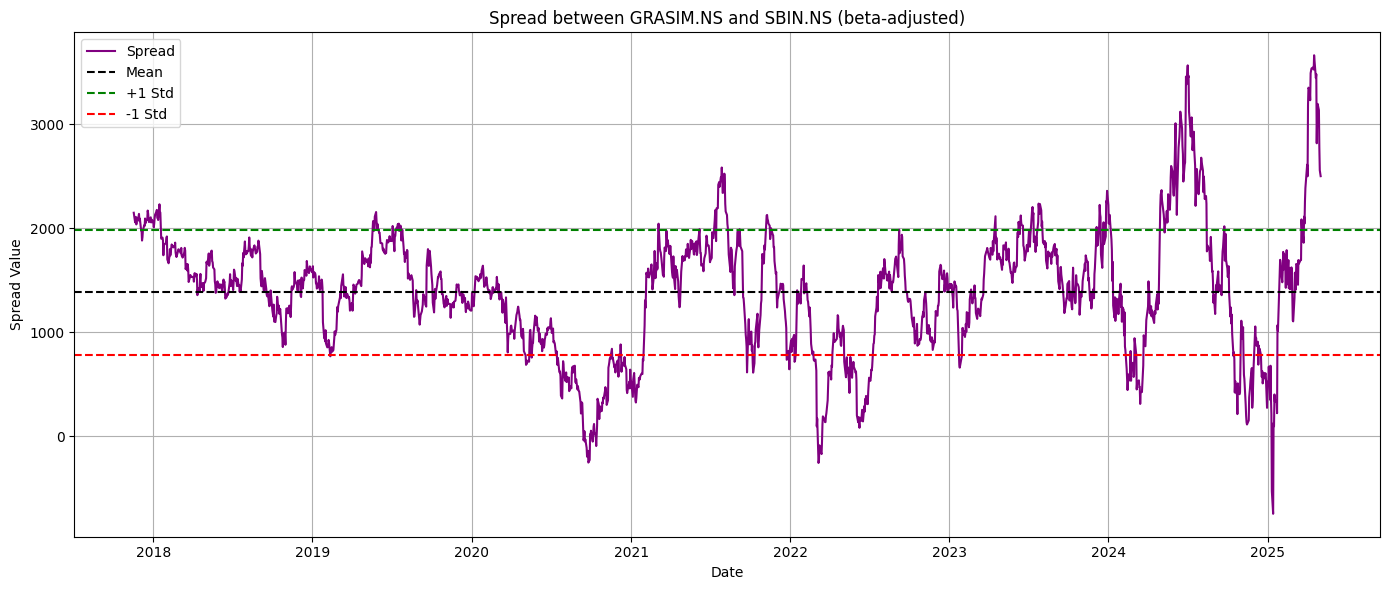

In [133]:


# Plotting the spread 
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(spread, label='Spread', color='purple', linewidth=1.5)
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 Std')
plt.axhline(spread.mean() - spread.std(), color='red', linestyle='--', label='-1 Std')
plt.title(f'Spread between {stockOne} and {stockTwo} (beta-adjusted)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [134]:
# Proceed with ADFS and KPSS tests

from statsmodels.tsa.stattools import adfuller, kpss

adf_p_value = adfuller(spread)[1]

kpss_p_value = kpss(spread, regression='c')[1]

print(f"ADF p-value: {adf_p_value}")
print(f"KPSS p-value: {kpss_p_value}")
if adf_p_value < 0.05 and kpss_p_value > 0.05:
  print("The spread is stationary. Proceed with trading.")
else:
  print("The spread is not stationary. Do not trade this pair.")


ADF p-value: 0.0008010471476892378
KPSS p-value: 0.1
The spread is stationary. Proceed with trading.


C:\Users\sparsh\AppData\Local\Temp\ipykernel_4480\1403927713.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
